# Simple logistic regression

This notebook follows John H McDonald's [Handbook of Biological Statistics](http://www.biostathandbook.com/simplelogistic.html) chapter on simple logistic regression.

This notebook is provided with a CC-BY-SA license.

In [41]:
import io
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

Spider data from *Suzuki et al. (2006)*:

In [2]:
data = """Grain size (mm)	Spiders
0.245	absent
0.247	absent
0.285	present
0.299	present
0.327	present
0.347	present
0.356	absent
0.36	present
0.363	absent
0.364	present
0.398	absent
0.4	present
0.409	absent
0.421	present
0.432	absent
0.473	present
0.509	present
0.529	present
0.561	absent
0.569	absent
0.594	present
0.638	present
0.656	present
0.816	present
0.853	present
0.938	present
1.036	present
1.045	present
"""
df = pd.read_table(io.StringIO(data))
df.Spiders = df.Spiders == 'present'
df.head()

,Grain size (mm),Spiders
0,0.245,False
1,0.247,False
2,0.285,True
3,0.299,True
4,0.327,True


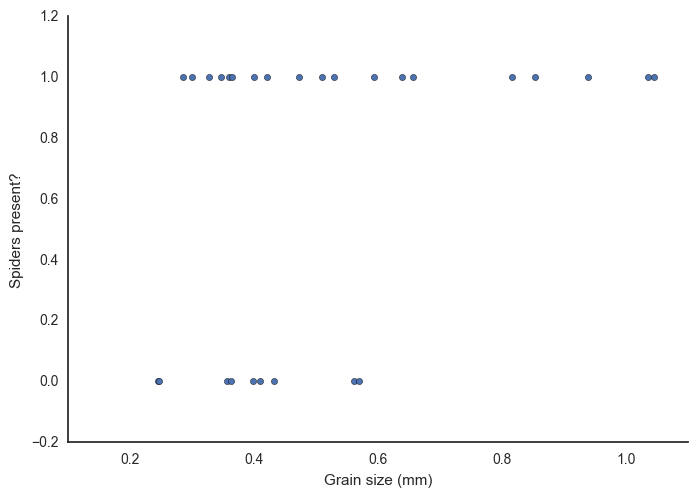

In [44]:
df.plot.scatter('Grain size (mm)', 'Spiders')
plt.ylabel('Spiders present?')
sns.despine()

I will analyse this with the *scikit-learn* package.

In [4]:
import sklearn.linear_model

scikit-learn has a logisitic regression classifier which uses regularization. To eliminate regularization, we set the regularization parameter `C` to $10^{12}$.

In [45]:
# C=1e12 is effectively no regularization - see https://github.com/scikit-learn/scikit-learn/issues/6738
clf = sklearn.linear_model.LogisticRegression(C=1e12, random_state=0)
clf.fit(df['Grain size (mm)'].reshape(-1, 1), df['Spiders'])
print(clf.intercept_, clf.coef_)

[-1.64748882] [[ 5.12118846]]


This is in agreement with the equation John reports:
$$
probability of spider presence = \frac{e^{-1.6476+5.1215(grain \; size)}}{(1+e^{-1.6476+5.1215(grain \; size)}}
$$

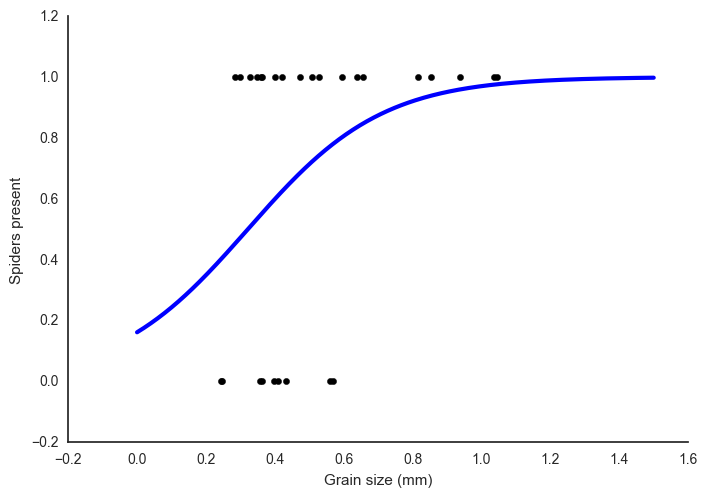

In [50]:
plt.scatter(df['Grain size (mm)'], df['Spiders'], color='black', zorder=20)
X_test = np.linspace(0, 1.5, 300)


def model(x):
    return 1 / (1 + np.exp(-x))
loss = model(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='blue', linewidth=3)

plt.xlabel('Grain size (mm)')
plt.ylabel('Spiders present')
sns.despine()

# Hypothesis testing

To test if *Grain size* is a significant factor, we use the [**likelihood ratio test**](https://en.wikipedia.org/wiki/Logistic_regression#Evaluating_goodness_of_fit).

We calculate the likelihood of the model with the grain size (the alternative model):

In [38]:
_ = clf.predict_proba(df['Grain size (mm)'].reshape(-1, 1))
df['prob_absent'], df['prob_present'] = _[:,0], _[:,1]
lik1 = df.loc[df['Spiders'], 'prob_present'].prod() * df.loc[~df['Spiders'], 'prob_absent'].prod()
lik1

2.2307140394522443e-07

We calculate the likelihood of the model without the grain size - the null model - which assumes that the sample distribution is the population distribution:

In [52]:
H0_prob = df['Spiders'].mean()
lik0 = H0_prob**(df['Spiders'].sum()) * (1 - H0_prob)**((1-df['Spiders']).sum())
lik0

2.3124700968640012e-08

We calculate the test statistic `D` which is approximately chisquare distributed with df=1 (one extra parameter in our alternative model):

In [53]:
D = -2 * np.log(lik0 / lik1)
D

4.5331811300854428

In [56]:
pval = scipy.stats.distributions.chi2.sf(D, df=1)
print('P = {:.8f}'.format(pval))

P = 0.03324377


John indeed reports 0.033.